In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [3]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder 
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    decoder = Chain(
        Dense(20, 500, relu, bias = false),
        Dense(500, 500, relu, bias = false),
        Dense(500, 784, sigmoid, bias = false)
    )

    return encoder_μ, encoder_logvar, decoder
end

create_vae (generic function with 1 method)

In [6]:
function vae_loss(encoder_μ, encoder_logvar, decoder, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)

    
    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(binarycrossentropy.(x̂, x)) 
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, decoder))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg 
end

function train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [8]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 20
save_dir = "trained_GNN/test/trained_GNN/MNIST_base"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, decoder = create_vae()
train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, ADAM(η), save_dir)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\Babhru\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Training a epoch done 100%|██████████████████████████████| Time: 0:07:55
  loss:  6608.416


Saving model...Done
Training complete!


In [10]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder 
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 30
    epoch_to_load = 20
    # Load the model and test set loader
    dir = "trained_GNN/test/trained_GNN/MNIST_base"
    encoder_μ, encoder_logvar, decoder = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [11]:
visualise()

Loading model...Done


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:195


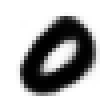

In [13]:
load("trained_GNN/test/trained_GNN/MNIST_base/reconstruction-3.png")

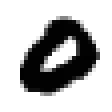

In [14]:
load("trained_GNN/test/trained_GNN/MNIST_base/test-image-3.png")

In [9]:
using NBInclude
@nbinclude("functions.ipynb")
epoch_to_load = 20
# Load the model and test set loader
dir = "trained_GNN/MNIST_identity_v2"
encoder_μ, encoder_logvar, decoder, decoder_last = load_model_identity(dir, epoch_to_load)
colorview(Gray, reshape(decoder_last * decoder(randn(20)), 28,28)' )
F = dct(diagm(ones(784)),2);
subspace_incoherence(F,decoder_last)


maximum(reshape(decoder_last * decoder(randn(20)), 28,28))

All function imported
Loading model...Done

168.95012937641698

In [ ]:
x_dim = 400
k = 10
F = dct(diagm(ones(x_dim)),2);
A = sample_fourier(k,x_dim); A = A'
print(A[1,1])
function loss(F,A)
    maximum(sqrt.(sum((A'*F').*(A'*F'), dims = 1))) + norm(A'*A - I(k),2)^2
end
θ = Flux.params(A)
# gs = gradient(()->loss(F), θ)
# Flux.Optimise.update!(opt, A, gs[A]);

opt = Descent(.1)
for i in 1:100
    gs = gradient(()->loss(F,A), A)
    Flux.Optimise.update!(opt, A, gs[A]);
    # A = A + randn(400,10)*.5^i
    # θ = Flux.params(A)

end

gs[A]
